<a href="https://colab.research.google.com/github/tsato-code/colab_notebooks/blob/main/video_classicication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# gpu
!nvidia-smi

Sun Mar 21 09:23:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# ファイルのダウンロードと展開
!mkdir -p datasets
%cd datasets/
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
!unrar e UCF101.rar Videos/
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101TrainTestSplits-RecognitionTask.zip
!unzip UCF101TrainTestSplits-RecognitionTask.zip

ストリーミング出力は最後の 5000 行に切り捨てられました。
Extracting  Videos/v_PlayingGuitar_g04_c01.avi                            61%  OK 
Extracting  Videos/v_PlayingGuitar_g04_c02.avi                            61%  OK 
Extracting  Videos/v_PlayingGuitar_g04_c03.avi                            61%  OK 
Extracting  Videos/v_PlayingGuitar_g04_c04.avi                            61%  OK 
Extracting  Videos/v_PlayingGuitar_g04_c05.avi                            61%  OK 
Extracting  Videos/v_PlayingGuitar_g04_c06.avi                            61%  OK 
Extracting  Videos/v_PlayingGuitar_g04_c07.avi                            61%  OK 
Extracting  Videos/v_PlayingGuitar_g05_c01.avi                            61%  OK 
Extracting  Videos/v_PlayingGuitar_g05_c02.avi                            61%  OK 
Extracting  Videos/v_PlayingGuitar_g05_c03.avi                            61%  OK 
Extracting  Videos/v_PlayingGuitar_g05_c04.avi  

In [3]:
# colabで動画再生するためのライブラリ
!pip install -U kora

     |████████████████████████████████| 61kB 5.0MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 


In [6]:
from glob import glob
import math
import os
import sys

from IPython.display import HTML
from kora.drive import upload_public
from scipy import stats
from tqdm.notebook import tqdm
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from moviepy.editor import VideoFileClip
import numpy as np
import pandas as pd

from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
from keras.models import Sequential
from keras.preprocessing import image
from keras.utils import np_utils, plot_model
from skimage.transform import resize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import keras

In [7]:
# サンプル動画
path = '/content/datasets/Videos/v_HighJump_g17_c03.avi'
clip = VideoFileClip(path)
clip.ipython_display(width=280)

100%|██████████| 116/116 [00:00<00:00, 888.29it/s]


In [8]:
# 訓練用動画名のリストを取得
with open('/content/datasets/ucfTrainTestlist/trainlist01.txt', 'r') as f:
    temp = f.read()

videos = temp.split('\n')

# データフレームに格納
train = pd.DataFrame()
train['video_name'] = videos
train = train[:-1]

# 検証用動画名のリストを取得
with open('/content/datasets/ucfTrainTestlist/testlist01.txt', 'r') as f:
    temp = f.read()

videos = temp.split('\n')

# データフレームに格納
test = pd.DataFrame()
test['video_name'] = videos
test = test[:-1]

In [9]:
# 訓練用動画にタグづけ
train_video_tag = []
for i in range(train.shape[0]):
    train_video_tag.append(train['video_name'][i].split('/')[0])

train['tag'] = train_video_tag

# 検証用動画にタグ付け
test_video_tag = []
for i in range(test.shape[0]):
    test_video_tag.append(test['video_name'][i].split('/')[0])

test['tag'] = test_video_tag

# データフレームのサイズ
print(train.shape, test.shape)

(9537, 2) (3783, 2)


In [10]:
# 先頭行確認
display(train.head())
display(test.head())

,video_name,tag
0,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi 1,ApplyEyeMakeup
1,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c02.avi 1,ApplyEyeMakeup
2,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c03.avi 1,ApplyEyeMakeup
3,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c04.avi 1,ApplyEyeMakeup
4,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c05.avi 1,ApplyEyeMakeup


,video_name,tag
0,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi,ApplyEyeMakeup
1,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi,ApplyEyeMakeup
2,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c03.avi,ApplyEyeMakeup
3,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c04.avi,ApplyEyeMakeup
4,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c05.avi,ApplyEyeMakeup


In [11]:
# 動画を1秒ごとにjpgとして保存
os.makedirs('/content/datasets/train_1', exist_ok=True)
for i in tqdm(range(train.shape[0])):
    count = 0
    video_file = train['video_name'][i]
    cap = cv2.VideoCapture('/content/datasets/Videos/'+video_file.split(' ')[0].split('/')[1])
    frame_rate = cap.get(5)

    while cap.isOpened():
        frame_id = cap.get(1)
        ret, frame = cap.read()

        if not ret:
            break
        if frame_id % math.floor(frame_rate) == 0:
            file_name = 'train_1/' + video_file.split('/')[1].split(' ')[0] + f'_frame{count}.jpg'
            count += 1
            cv2.imwrite(file_name, frame)

    cap.release()

In [12]:
# 読み込み数上限を指定
NUM_UPPER_FILES = 2000

# 動画ファイル名を取得
images = sorted(glob('/content/datasets/train_1/*.jpg'))[:NUM_UPPER_FILES]
train_image = []
train_class = []
for i in tqdm(range(len(images))):
    train_image.append(images[i].split('/')[4])
    train_class.append(images[i].split('/')[4].split('_')[1])

# データフレーム化
train_data = pd.DataFrame()
train_data['image'] = train_image
train_data['class'] = train_class

# csv出力
train_data.to_csv('/content/datasets/Videos/train_new.csv', header=True, index=False)
del train_data

In [13]:
# csv入力
train = pd.read_csv('/content/datasets/Videos/train_new.csv')
train.head()

,image,class
0,v_ApplyEyeMakeup_g08_c01.avi_frame0.jpg,ApplyEyeMakeup
1,v_ApplyEyeMakeup_g08_c01.avi_frame1.jpg,ApplyEyeMakeup
2,v_ApplyEyeMakeup_g08_c01.avi_frame2.jpg,ApplyEyeMakeup
3,v_ApplyEyeMakeup_g08_c01.avi_frame3.jpg,ApplyEyeMakeup
4,v_ApplyEyeMakeup_g08_c01.avi_frame4.jpg,ApplyEyeMakeup


In [14]:
# メモリ状況確認
print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 1024 * 2024:
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 


In [15]:
# ファイル取り込み
train_image = []

for i in tqdm(range(min(NUM_UPPER_FILES, train.shape[0]))):
    # ファイル読み込み
    img = image.load_img('/content/datasets/train_1/'+train['image'][i], target_size=(224, 224, 3))
    # 型変換
    img = image.img_to_array(img)
    # 標準化
    img /= 255
    # リストに追加
    train_image.append(img)

# リストを変換
X = np.array(train_image)
# シェイプ
print(X.shape)


(2000, 224, 224, 3)


In [16]:
# 教師データ
y = train['class'][:NUM_UPPER_FILES]

# 訓練データと検証データに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

# targetのダミー化
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [17]:
# 事前学習モデル読み込み
base_model = VGG16(weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 0s 0us/step


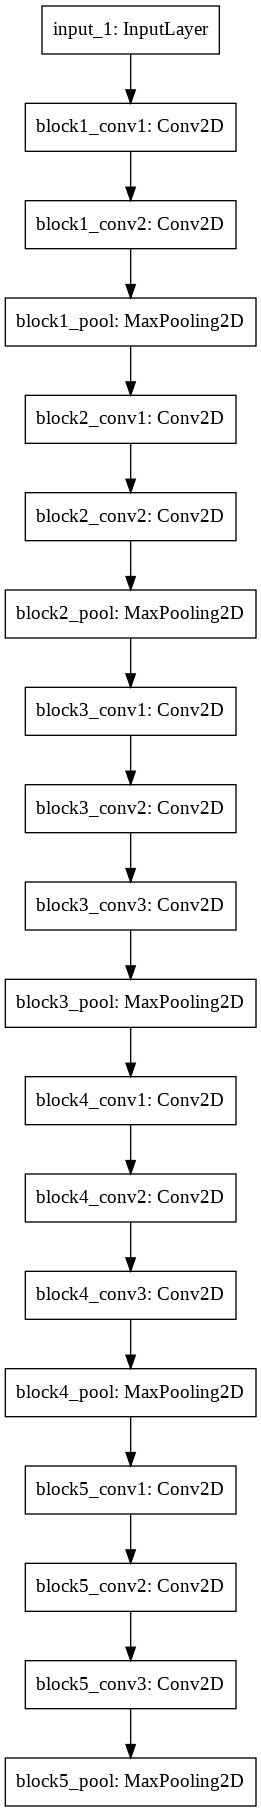

In [19]:
# モデル確認
plot_model(base_model)

In [20]:
# 特徴量抽出
X_train = base_model.predict(X_train)
X_test = base_model.predict(X_test)

# シェイプ
print(X_train.shape, X_test.shape)

(1600, 7, 7, 512) (400, 7, 7, 512)


In [22]:
# reshape
X_train = X_train.reshape(1600, 7*7*512)
X_test = X_test.reshape(400, 7*7*512)

# 標準化
max_val = X_train.max()
X_train = X_train / max_val
X_test = X_test / max_val

# シェイプ
print(X_train.shape, X_test.shape)

(1600, 25088) (400, 25088)


In [23]:
# モデル
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(25088,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))

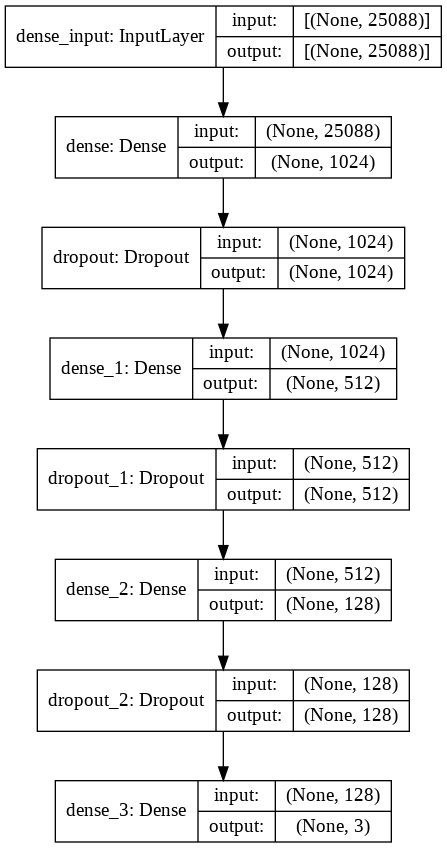

In [25]:
# モデル確認
plot_model(model, show_shapes=True)

In [26]:
# モデル訓練
mcp_save = ModelCheckpoint('/content/datasets/weight.hdf5', 
                           save_best_only=True,
                           monitor='val_loss',
                           mode='min')

model.compile(loss='categorical_crossentropy',
              optimizer='Adam', 
              metrics=['accuracy'])

model.fit(X_train, 
          y_train, 
          epochs=200, 
          validation_data=(X_test, y_test),
          callbacks=[mcp_save],
          batch_size=128)

Epoch 1/200
13/13 [==============================] - 1s 32ms/step - loss: 0.9583 - accuracy: 0.4866 - val_loss: 0.1953 - val_accuracy: 0.9750
Epoch 2/200
13/13 [==============================] - 0s 19ms/step - loss: 0.2549 - accuracy: 0.8969 - val_loss: 0.0190 - val_accuracy: 0.9950
Epoch 3/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0617 - accuracy: 0.9784 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 4/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0161 - accuracy: 0.9966 - val_loss: 1.1342e-04 - val_accuracy: 1.0000
Epoch 5/200
13/13 [==============================] - 0s 15ms/step - loss: 0.0059 - accuracy: 0.9978 - val_loss: 9.7739e-05 - val_accuracy: 1.0000
Epoch 6/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 5.0095e-05 - val_accuracy: 1.0000
Epoch 7/200
13/13 [==============================] - 0s 14ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.7387e-05 - val_accurac

In [27]:
# テストデータ
with open('/content/datasets/ucfTrainTestlist/testlist01.txt', 'r') as f:
    temp = f.read()

videos = temp.split('\n')

test = pd.DataFrame()
test['video_name'] = videos
test = test[:-1]
test_videos = test['video_name']
test.head()

,video_name
0,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi
1,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi
2,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c03.avi
3,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c04.avi
4,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c05.avi


In [28]:
y = train['class']
y = pd.get_dummies(y)

In [29]:
os.makedirs('/content/datasets/temp', exist_ok=True)

predict = []
actual = []

for i in tqdm(range(test_videos.shape[0])):
    count = 0
    video_file = test_videos[i]
    cap = cv2.VideoCapture('/content/datasets/Videos/'+video_file.split(' ')[0].split('/')[1])
    frame_rate = cap.get(5)
    
    files = glob('/content/datasets/temp/*')
    for f in files:
        os.remove(f)
    while cap.isOpened():
        frame_id = cap.get(1)
        ret, frame = cap.read()

        if not ret:
            break
        if  frame_id % math.floor(frame_rate) == 0:
            file_name = '/content/datasets/temp/' + f'_frame{count}.jpg'
            count += 1
            cv2.imwrite(file_name, frame)

    cap.release()

    images = glob('/content/datasets/temp/*.jpg')
    pred_images = []

    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(224, 224, 3))
        img = image.img_to_array(img)
        img /= 255
        pred_images.append(img)

    pred_images = np.array(pred_images)
    pred_images = base_model.predict(pred_images)
    pred_images = pred_images.reshape(pred_images.shape[0], 7*7*512)
    pred = model.predict_classes(pred_images)
    predict.append(y.columns.values[stats.mode(pred)[0][0]])
    actual.append(video_file.split('/')[1].split('_')[1])


In [30]:
# accuracy
accuracy_score(actual, predict)

0.024054982817869417